# The risk of fatality of each Youbike station 

#### The idea is Risk = Exposure x Hazzard
#### where
#### Exposure = the ridership of each station 
#### Hazzard = the fatality of accidents 

## Initialization

In [1]:
# importing modules
# use 'pip install' + [module_name] to install the module when needed

import os 
import csv
import json
import zipfile
import requests
import numpy as np
import pandas as pd
import seaborn as sns
import geopy.distance as gp
import matplotlib.pyplot as plt
from math import sin, cos, sqrt, atan2, radians

In [2]:
# data sets url

# A1及A2交通事故資料
url_acc = r'https://data.taipei/api/dataset/2f238b4f-1b27-4085-93e9-d684ef0e2735/resource/ebdbe6de-71da-4a42-aed4-21b818e79f70/download'

# 臺北市公共自行車2.0租借紀錄
url_rides_v2 = r'https://tcgbusfs.blob.core.windows.net/dotapp/youbike_second_ticket_opendata/YouBikeHis.csv'

# 臺北市公共自行車租借紀錄 (1.0)
url_rides_v1 = r'https://tcgbusfs.blob.core.windows.net/dotapp/youbike_ticket_opendata/YouBikeHis.csv'

# YouBike2.0臺北市公共自行車即時資訊 -> 只要取站點位置
url_station_v2 = r'https://tcgbusfs.blob.core.windows.net/dotapp/youbike/v2/youbike_immediate.json'

# YouBike臺北市公共自行車即時資訊 (1.0) -> 只要取站點位置
# note: aquired from https://data.taipei/api/dataset/8ef1626a-892a-4218-8344-f7ac46e1aa48/resource/0d635fa0-2a02-4278-af79-415d2d27207b/download
url_station_v1 = r'https://tcgbusfs.blob.core.windows.net/blobyoubike/YouBikeTP.json'

In [3]:
# function to be used

# 無法直接透過url直接擷取的資料用下載的方式取得
def download_url(url, save_path, chunk_size=128):
    
    r = requests.get(url, stream=True)
    
    with open(save_path, 'wb') as fd:
        for chunk in r.iter_content(chunk_size=chunk_size):
            fd.write(chunk)
            
    return


# 計算gps座標距離   
def get_gpsDistance(latitude1, longitude1, latitude2, longitude2): 
    
    # approximate radius of earth in km
    R = 6373.0
    
    # python treat angle in radians by default
    lat1 = radians(latitude1)
    lon1 = radians(longitude1)
    lat2 = radians(latitude2)
    lon2 = radians(longitude2)

    dlon = lon2 - lon1
    dlat = lat2 - lat1
    
    # Haversine formula
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    
    return R * c

## Aquiring Data Sets: *df_acc_bike, df_station_info, df_rides*

In [4]:
# Aquire A1 A2 accident data df_acc_bike
# Definition: A1-Died within 24 hours, A2-Die over 24 hours

# column to use: col 6('處理別'), 12('車種'), 50('x':latitude), 51('y':lontitude), not a problem in this case

# unable to read csv directly, download to local dir instead
acc_filePath = 'data/acc.csv'
download_url(url_acc, acc_filePath)

# read from local dir 
df_acc_bike = pd.read_csv(acc_filePath, encoding="big5")

# extract the accidents with bikes F01 
df_acc_bike = df_acc_bike[df_acc_bike['車種'] == 'F01']

# to see the ratio of litigant order in bike accidents
litigant = len(df_acc_bike.index)
litigant1 = len(df_acc_bike[df_acc_bike['處理別'] == 1].index)
litigant2 = len(df_acc_bike[df_acc_bike['處理別'] != 1].index)

print(f'2021自行車A1A2車禍當事人共 {litigant} 位, 其中第一當事人 {litigant1} 位, 第二及其後順位當事人共 {litigant2} 位')

# non-Primary litigent are majority, still take Primary litigent into account
df_acc_bike

2021自行車A1A2車禍當事人共 1296 位, 其中第一當事人 3 位, 第二及其後順位當事人共 1293 位


發生年  發生月  發生日  發生時  發生分  處理別     區序                  肇事地點  死亡人數  \
87     110    1    1   17   53    2  08士林區        士林區延平北路5段與葫蘆街口     0   
166    110    1    2   12   35    2  05中正區       中正區重慶南路3段與寧波西街口     0   
273    110    1    3    8   58    2  03中山區  中山區新生北路2段與新生北路2段15巷口     0   
304    110    1    3   12    6    2  07信義區           信義區松智路與松勤街口     0   
309    110    1    3   12   55    2  01大同區           大同區南京西路426號     0   
...    ...  ...  ...  ...  ...  ...    ...                   ...   ...   
55269  110   12   31   11    9    2  03中山區      中山區龍江路與龍江路377巷口口     0   
55315  110   12   31   17   50    2  09北投區           北投區關渡河堤自行車道     0   
55316  110   12   31   17   50    2  09北投區           北投區關渡河堤自行車道     0   
55318  110   12   31   18   12    2  08士林區       士林區中正路與承德路5段口引道     0   
55336  110   12   31   21   55    2  04大安區         大安區大安路1段與東豐街口     0   

       2-30日死亡人數  ...  飲酒情形  車輛撞擊部位1 車輛撞擊部位2  肇因碼-個別  肇因碼-主要  個人肇逃否    職業  \
87             0  ...   3.0     16.0     NaN    21.0      10    1.0  22.0   
166            0  ...   2.0     16.0     NaN    44.0      42    1.0  22.0   
273            0  ...   1.0     16.0     NaN    11.0       6    1.0  22.0   
304            0  ...   1.0     16.0     NaN    43.0      43    1.0  22.0   
309            0  ...   2.0     16.0     NaN    23.0      12    1.0  22.0   
...          ...  ...   ...      ...     ...     ...     ...    ...   ...   
55269          0  ...   1.0     16.0     NaN    23.0       6    1.0  22.0   
55315          0  ...   1.0     16.0     NaN     1.0       1    1.0  22.0   
55316          0  ...   1.0     16.0     NaN    44.0       1    1.0  22.0   
55318          0  ...   2.0     16.0     NaN    44.0      23    1.0  22.0   
55336          0  ...   1.0     16.0     NaN    27.0       6    1.0  22.0   

       旅次目的           X          Y  
87      9.0  121.509907  25.084114  
166     9.0  121.515328  25.029788  
273     9.0  121.527793  25.053068  
304     9.0  121.565428  25.031982  
309     9.0  121.509195  25.053307  
...     ...         ...        ...  
55269   9.0  121.540960  25.064760  
55315   9.0  121.465493  25.115181  
55316   9.0  121.465493  25.115181  
55318   9.0  121.515472  25.090474  
55336   9.0  121.545921  25.036057  

[1296 rows x 51 columns]

In [5]:
# get Youbike station coordinates info 

# hadeling json file for 1.0 and 2.0
df_station_v1_jret = pd.read_json(url_station_v1)
list_statiion_v1 = df_station_v1_jret['retVal'].to_list()
df_info_v1 = pd.DataFrame(list_statiion_v1)
df_info_v2 = pd.read_json(url_station_v2)

# make station name as key : 'station'
df_info_v1.rename(columns={'sna': 'station'},inplace=True) 
df_info_v2['station'] = df_info_v2['sna'].str.split('YouBike2.0_').apply(lambda x: x[1])

# drop unnecessary col
df_info_v1.drop(['sno','tot','sbi','sarea','mday','ar','sareaen','snaen','aren','bemp','act'],axis=1, inplace=True)
df_info_v2.drop(['sna','sno','tot','sbi','sarea','mday','ar','sareaen','snaen','aren','bemp','act','srcUpdateTime','updateTime','infoTime','infoDate'],axis=1,inplace=True)

# youbike version as another key to use
df_info_v1['Youbike_version'] = 1
df_info_v2['Youbike_version'] = 2

# concatenate as one df
df_station_info = pd.concat([df_info_v1, df_info_v2])

# release memory
del df_station_v1_jret, list_statiion_v1, df_info_v1, df_info_v2

df_station_info

station            lat            lng  Youbike_version
0       捷運市政府站(3號出口)  25.0408578889  121.567904444                1
1     捷運國父紀念館站(2號出口)      25.041254      121.55742                1
2               市民廣場  25.0360361111     121.562325                1
3               興雅國中  25.0365638889    121.5686639                1
4             臺北南山廣場      25.034047     121.565973                1
...              ...            ...            ...              ...
1121       臺大總圖書館西南側        25.0169      121.54031                2
1122         臺大黑森林西側       25.01995      121.54347                2
1123         臺大獸醫館南側       25.01791      121.54242                2
1124       臺大新體育館東南側       25.02112      121.53591                2
1125   臺大明達館北側(員工宿舍)       25.01816      121.54469                2

[1501 rows x 4 columns]

In [6]:
# get ridership of Youbike 1.0 (marked as v1 when naming)

df_ride_month_v1 = pd.read_csv(url_rides_v1)

# get ridership table for the latest 12 month
#############################
nr_month = 12
###############################
url_series_v1 = df_ride_month_v1.head(nr_month)['fileURL']
url_list_v1 = url_series_v1.tolist()

df_list_v1 = []
temp_zip_path = 'data/temp_v1.zip'

col_names = ['rent_time','rent_station','return_time','return_station','rent','infodate']
for zip_url in url_list_v1:
    
    # save the file temporary and delete it later 
    download_url(zip_url, temp_zip_path)
    
    zf = zipfile.ZipFile(temp_zip_path, 'r')
    
    # get the .csv file in zipped file(s), some with dir some don't, so find it with .namelist()
    name_list_v1 = zf.namelist()
    for name in name_list_v1:
        if name.endswith('.csv'):
            # assign column name specifically for Youbike 1.0
            temp_df = pd.read_csv(zf.open(name), names=col_names, header=None)
            df_list_v1.append(temp_df)
    zf.close()

zf.close()
os.remove(temp_zip_path)
df_rides_v1 = pd.concat(df_list_v1)

# set Youbike_version as key 
df_rides_v1['Youbike_version'] = 1

# todo 
# not implemented at first. Added for the error find in EDA process
# df_rides_v1['rent_station'] = df_rides_v1['rent_station'].map(lambda x: x.lstrip('@'))
# df_rides_v1['return_station'] = df_rides_v1['return_station'].map(lambda x: x.lstrip('@'))

df_rides_v1

rent_time    rent_station          return_time  \
0        2022-04-12 09:00:00            喬治工商  2022-04-12 09:00:00   
1        2022-04-12 08:00:00    捷運劍南路站(2號出口)  2022-04-12 13:00:00   
2        2022-04-12 07:00:00            百齡國小  2022-04-12 07:00:00   
3        2022-04-12 19:00:00            華西公園  2022-04-12 21:00:00   
4        2022-04-12 17:00:00     臺北市客家文化主題公園  2022-04-12 17:00:00   
...                      ...             ...                  ...   
1576870  2021-05-04 08:00:00            萬華車站  2021-05-04 08:00:00   
1576871  2021-05-04 23:00:00           臺北轉運站  2021-05-04 23:00:00   
1576872  2021-05-04 08:00:00            健康新城  2021-05-04 08:00:00   
1576873  2021-05-04 07:00:00  捷運國父紀念館站(2號出口)  2021-05-04 08:00:00   
1576874  2021-05-04 09:00:00        羅斯福寧波東街口  2021-05-04 10:00:00   

         return_station     rent    infodate  Youbike_version  
0               吳興街260巷  0:04:20  2022-04-12                1  
1           捷運文德站(2號出口)  4:33:42  2022-04-12                1  
2           捷運劍潭站(2號出口)  0:05:57  2022-04-12                1  
3           捷運雙連站(2號出口)  1:26:08  2022-04-12                1  
4                  牯嶺公園  0:12:20  2022-04-12                1  
...                 ...      ...         ...              ...  
1576870    捷運小南門站(1號出口)  0:29:06  2021-05-04                1  
1576871            朱崙商場  0:14:08  2021-05-04                1  
1576872   捷運南京三民站(3號出口)  0:05:35  2021-05-04                1  
1576873        光復南路22巷口  1:16:57  2021-05-04                1  
1576874  信義杭州路口(中華電信總公司  1:05:42  2021-05-04                1  

[13456490 rows x 7 columns]

In [7]:
# get ridership of Youbike 2.0 (marked as v2 when naming)

df_ride_month_v2 = pd.read_csv(url_rides_v2)

################################
nr_month = 12
###############################

url_series_v2 = df_ride_month_v2.head(nr_month)['fileURL']
url_list_v2 = url_series_v2.tolist()

df_list_v2 = []
temp_zip_path = 'data/temp_v2.zip'

for zip_url in url_list_v2:
    
    download_url(zip_url, temp_zip_path)
    
    zf = zipfile.ZipFile(temp_zip_path, 'r')
    
    name_list_v2 = zf.namelist()
    for name in name_list_v2:
        if name.endswith('.csv'):
            temp_df = pd.read_csv(zf.open(name))
            df_list_v2.append(temp_df)
    zf.close()
    
zf.close()
os.remove(temp_zip_path)
df_rides_v2 = pd.concat(df_list_v2)

# set Youbike_version as key 
df_rides_v2['Youbike_version'] = 2
df_rides_v2

rent_time rent_station          return_time return_station  \
0       2022-04-12 13:00:00  文湖街81巷10號西側  2022-04-12 13:00:00    文湖街81巷10號西側   
1       2022-04-12 00:00:00       市民松信路口  2022-04-12 00:00:00  雅祥公園(松信路50巷口)   
2       2022-04-12 13:00:00      臺大樂學館東側  2022-04-12 13:00:00      臺大天文數學館南側   
3       2022-04-12 07:00:00  捷運石牌站(2號出口)  2022-04-12 07:00:00           振興醫院   
4       2022-04-12 13:00:00     臺大農化新館西側  2022-04-12 13:00:00    臺大第一活動中心西南側   
...                     ...          ...                  ...            ...   
269970  2021-05-09 08:00:00   承德路七段304巷口  2021-05-09 08:00:00   捷運復興崗站旅客服務中心   
269971  2021-05-09 07:00:00      羅斯福景隆街口  2021-05-09 08:00:00        羅斯福景隆街口   
269972  2021-05-09 08:00:00    臺大社科院圖書館前  2021-05-09 08:00:00       臺大社會系館南側   
269973  2021-05-09 08:00:00  捷運麟光站(2號出口)  2021-05-09 08:00:00    捷運麟光站(2號出口)   
269974  2021-05-09 08:00:00  捷運公館站(2號出口)  2021-05-09 08:00:00       臺大舊體育館西側   

            rent    infodate  Youbike_version  
0       00:11:20  2022-04-12                2  
1       00:28:13  2022-04-12                2  
2       00:03:53  2022-04-12                2  
3       00:15:03  2022-04-12                2  
4       00:03:00  2022-04-12                2  
...          ...         ...              ...  
269970  00:18:26  2021-05-09                2  
269971  01:24:32  2021-05-09                2  
269972  00:05:36  2021-05-09                2  
269973  00:23:36  2021-05-09                2  
269974  00:04:43  2021-05-09                2  

[12846252 rows x 7 columns]

In [8]:
# combined ridership of 1.0 and 2.0 
df_rides = pd.concat([df_rides_v1, df_rides_v2])

# releasing memory
del df_rides_v1, df_rides_v2

df_rides

rent_time  rent_station          return_time return_station  \
0       2022-04-12 09:00:00          喬治工商  2022-04-12 09:00:00        吳興街260巷   
1       2022-04-12 08:00:00  捷運劍南路站(2號出口)  2022-04-12 13:00:00    捷運文德站(2號出口)   
2       2022-04-12 07:00:00          百齡國小  2022-04-12 07:00:00    捷運劍潭站(2號出口)   
3       2022-04-12 19:00:00          華西公園  2022-04-12 21:00:00    捷運雙連站(2號出口)   
4       2022-04-12 17:00:00   臺北市客家文化主題公園  2022-04-12 17:00:00           牯嶺公園   
...                     ...           ...                  ...            ...   
269970  2021-05-09 08:00:00    承德路七段304巷口  2021-05-09 08:00:00   捷運復興崗站旅客服務中心   
269971  2021-05-09 07:00:00       羅斯福景隆街口  2021-05-09 08:00:00        羅斯福景隆街口   
269972  2021-05-09 08:00:00     臺大社科院圖書館前  2021-05-09 08:00:00       臺大社會系館南側   
269973  2021-05-09 08:00:00   捷運麟光站(2號出口)  2021-05-09 08:00:00    捷運麟光站(2號出口)   
269974  2021-05-09 08:00:00   捷運公館站(2號出口)  2021-05-09 08:00:00       臺大舊體育館西側   

            rent    infodate  Youbike_version  
0        0:04:20  2022-04-12                1  
1        4:33:42  2022-04-12                1  
2        0:05:57  2022-04-12                1  
3        1:26:08  2022-04-12                1  
4        0:12:20  2022-04-12                1  
...          ...         ...              ...  
269970  00:18:26  2021-05-09                2  
269971  01:24:32  2021-05-09                2  
269972  00:05:36  2021-05-09                2  
269973  00:23:36  2021-05-09                2  
269974  00:04:43  2021-05-09                2  

[26302742 rows x 7 columns]

In [252]:
# adding coord. to ridership table to see the trip length distribution

# join twice with info table for rent and return station 
rent_info = df_station_info.rename(columns = {'station': 'rent_station', 'lat':'rent_lat', 'lng':'rent_lng'})
return_info = df_station_info.rename(columns = {'station': 'return_station', 'lat':'return_lat', 'lng':'return_lng'})

df_rides = df_rides.merge(rent_info, on =['rent_station','Youbike_version'], how ='left')
df_rides = df_rides.merge(return_info, on =['return_station','Youbike_version'], how ='left')

# clean memory for temporary df 
del rent_info, return_info

# calculate trip length(linear distance)
df_rides['trip_length'] = df_rides.apply(lambda x: get_gpsDistance(float(x['rent_lat']), float(x['rent_lng']), float(x['return_lat']), float(x['return_lng'])), axis=1)

df_rides

rent_time  rent_station          return_time  \
0         2022-04-12 09:00:00          喬治工商  2022-04-12 09:00:00   
1         2022-04-12 08:00:00  捷運劍南路站(2號出口)  2022-04-12 13:00:00   
2         2022-04-12 07:00:00          百齡國小  2022-04-12 07:00:00   
3         2022-04-12 19:00:00          華西公園  2022-04-12 21:00:00   
4         2022-04-12 17:00:00   臺北市客家文化主題公園  2022-04-12 17:00:00   
...                       ...           ...                  ...   
26302737  2021-05-09 08:00:00    承德路七段304巷口  2021-05-09 08:00:00   
26302738  2021-05-09 07:00:00       羅斯福景隆街口  2021-05-09 08:00:00   
26302739  2021-05-09 08:00:00     臺大社科院圖書館前  2021-05-09 08:00:00   
26302740  2021-05-09 08:00:00   捷運麟光站(2號出口)  2021-05-09 08:00:00   
26302741  2021-05-09 08:00:00   捷運公館站(2號出口)  2021-05-09 08:00:00   

         return_station      rent    infodate  Youbike_version   rent_lat  \
0               吳興街260巷   0:04:20  2022-04-12                1  25.027123   
1           捷運文德站(2號出口)   4:33:42  2022-04-12                1   25.08418   
2           捷運劍潭站(2號出口)   0:05:57  2022-04-12                1   25.08521   
3           捷運雙連站(2號出口)   1:26:08  2022-04-12                1  25.038609   
4                  牯嶺公園   0:12:20  2022-04-12                1   25.02043   
...                 ...       ...         ...              ...        ...   
26302737   捷運復興崗站旅客服務中心  00:18:26  2021-05-09                2    25.1168   
26302738        羅斯福景隆街口  01:24:32  2021-05-09                2   24.99898   
26302739       臺大社會系館南側  00:05:36  2021-05-09                2   25.02101   
26302740    捷運麟光站(2號出口)  00:23:36  2021-05-09                2    25.0181   
26302741       臺大舊體育館西側  00:04:43  2021-05-09                2   25.01491   

            rent_lng return_lat  return_lng  trip_length  
0         121.555566  25.026100  121.563160     0.773786  
1         121.555116  25.078424   121.58456     3.034546  
2         121.519175  25.082825  121.524721     0.618483  
3         121.498495  25.058210  121.520590     3.116180  
4         121.525322  25.023377  121.518835     0.731396  
...              ...        ...         ...          ...  
26302737    121.5048   25.13666   121.48159     3.216049  
26302738    121.5403   24.99898    121.5403     0.000000  
26302739   121.54284   25.01987   121.54175     0.167775  
26302740   121.55929    25.0181   121.55929     0.000000  
26302741   121.53438    25.0198   121.53583     0.563207  

[26302742 rows x 12 columns]

In [9]:
# This step might take long time and huge memory
# use the following lines of code in case you need to save it to local dir, 
# or when you need to use the one I prepared as a backup plan

# to save df_rides 
# df_rides.to_csv('data/df_rides.csv', index=False)

# to load df_rides (this would be faster)
# df_rides = pd.read_csv('data/df_rides.csv')

## EDA Process

In [10]:
# inspect the data 
df_rides.isnull().sum()

rent_time                0
rent_station             1
return_time              0
return_station          25
rent                     0
infodate                 0
Youbike_version          0
rent_lat            741127
rent_lng            741127
return_lat         1423293
return_lng         1423293
trip_length        2038602
dtype: int64

In [255]:
# drop trips with uncompleted trip where rent/return station is null
df_rides.drop(df_rides[df_rides['return_station'].isnull()].index, inplace=True)
df_rides.drop(df_rides[df_rides['rent_station'].isnull()].index, inplace=True)

df_rides.isnull().sum()

rent_time                0
rent_station             0
return_time              0
return_station           0
rent                     0
infodate                 0
Youbike_version          0
rent_lat            741124
rent_lng            741124
return_lat         1423268
return_lng         1423268
trip_length        2038576
dtype: int64

In [256]:
# check whether those unmatched station are in Taipei (as the df_station_info is based on Taipei)
rent_null = pd.unique(df_rides[df_rides['rent_lat'].isnull()]['rent_station'])
return_null = pd.unique(df_rides[df_rides['return_lat'].isnull()]['return_station'])
station_null = np.unique(np.append(rent_null,return_null))

# only print out when needed
# for s in station_null:
#     print(s)

# note: find out some station names starts with @ in Youbike 1.0 at first
# others umatched station are mostly in New Taipei City
# only a few unmathched in Taipei with uncomplete name(string too long)
# These problems do not affect the project much, they will be handled later if there is time (todo)

?公公園
?林國小
@二重維修中心
@光復南路22巷口
@台北市政府
@新店維護所
@東新國小
@福德公園
@臺大卓越維護站
@莒光大埔街口
@蘆洲維修中心
三井Outlet
三光國小(金滿意)
三坑自然生態公園
三多國小
三多第1市民活動中心
三峽區公所(三峽老街)
三峽區礁溪行政中心
三峽國中
三峽國光青年社會住宅
三張公園
三德公園
三抱竹
三樹大德路口
三民中山一路口
三民翠華街口
三民運動公園
三民高中(民權路)
三重五常公園
三重商工
三重商工(後竹圍街)
三重商工地下停車場
三重國民運動中心
三重棒球場
三重永豐公園
三重綜合體育館
三重行政中心
三重親水公園
三重高中
三鶯國民運動中心
上林里(環河東路一段)
下庄市場
世貿國家公園社區
中信國小
中印青潭廠
中原公園
中原大學
中原東街(左岸牡丹園)
中和公園
中和區公所
中和國民運動中心
中和地政事務所
中和安和路口
中和環球購物中心
中和自強公園
中和青年社會住宅
中國科技大樓
中園國小
中壢區公所
中壢新興公園
中壢火車站(前站)
中壢火車站(後站)
中壢藝術館
中央中華路口(金城)
中央大學圖書館
中央慶利街口(風華綠中央社區
中央路一段292巷口
中寧公園
中山1號科技總部
中山八德街口
中山北新春街口
中山國中
中山大安路口
中山新興街口
中山環金路口
中山立仁街口
中平國中
中德里休閒廣場
中德里市民活動中心
中正一正康一街口
中正仁愛街口
中正光明路口
中正公園(中美路)
中正北路193巷(愛買三重店)
中正國小
中正富國路口
中正新月二街口(富江翠社區)
中正新雅巷口
中正橋
中正民權路口
中正淡海路口
中正福海街口
中正莊敬路口
中正路161巷口
中正路284巷
中正路347巷口
中正路666巷口
中正雙鳳路口
中港國小
中港大排願景館
中科院五號門
中科院石園三村
中興中正路口
中興北街175巷口
中興北街42巷17弄
中興寶慶街口
中興寶橋路口
中興橋(環河南路254巷口)
中興路2段100巷口
中興路二段100巷口
中華中原路口
中華中央路一段242巷口
中華城林路口
中華愛國路口
中華自治街口
中華裕華街口
中華里(中華路二段)
中華電信學院
中角灣
中路兒2公園
丹鳳派出所
二橋虹橋公園
二重國中
二重國小
五堵火車站
五峰國中
五福里(五華街)
五股國民運動中心
五股

In [261]:
# see discriptive statics
# convert column "rent" into minute, not carrying
df_rides['rent_minutes'] = df_rides['rent'].str.split(':').apply(lambda x: int(x[0]) * 60 + int(x[1]))

# see the time period distribution of rent and return 
df_rides['rent_time_hr'] = pd.to_datetime(df_rides['rent_time']).dt.strftime('%H')
df_rides['return_time_hr'] = pd.to_datetime(df_rides['return_time']).dt.strftime('%H')

# to see whether to exclude the extreme value. 
# They are reasonable, but not typical in behavior.
trip99 = df_rides['trip_length'].quantile(0.99)
min99 = df_rides['rent_minutes'].quantile(0.99)
print(f"99% people travle less than {round(trip99,1)} km (max {round(df_rides['trip_length'].max(),1)} km) in less than {round(min99)} minutes (max {df_rides['rent_minutes'].max()} minutes)")
print('note: these 2 groups of people are not the same group of people')

df_rides.describe(include='all')
# avg trip length = ~ 1.7 km in pilot
# avg travel time = ~ 21.0 min in pilot

99% people travle less than 6 km (max 19.45209621503417 km) in less than 157 minutes (max 137585 km)
note: these 2 groups of people are not the same group of people


rent_time rent_station          return_time return_station  \
count              26302716     26302716             26302716       26302716   
unique                 8742         1127                 8750           2011   
top     2022-03-15 18:00:00  捷運公館站(2號出口)  2022-03-15 18:00:00    捷運公館站(2號出口)   
freq                  12748       401591                13242         414623   
mean                    NaN          NaN                  NaN            NaN   
std                     NaN          NaN                  NaN            NaN   
min                     NaN          NaN                  NaN            NaN   
25%                     NaN          NaN                  NaN            NaN   
50%                     NaN          NaN                  NaN            NaN   
75%                     NaN          NaN                  NaN            NaN   
max                     NaN          NaN                  NaN            NaN   

            rent    infodate  Youbike_version      rent_lat      rent_lng  \
count   26302716    26302716     2.630272e+07  2.556159e+07  2.556159e+07   
unique     56462         365              NaN  1.361000e+03  1.368000e+03   
top     00:05:07  2022-03-11              NaN  2.501491e+01  1.215344e+02   
freq       17712      122804              NaN  2.633910e+05  2.633910e+05   
mean         NaN         NaN     1.488399e+00           NaN           NaN   
std          NaN         NaN     4.998654e-01           NaN           NaN   
min          NaN         NaN     1.000000e+00           NaN           NaN   
25%          NaN         NaN     1.000000e+00           NaN           NaN   
50%          NaN         NaN     1.000000e+00           NaN           NaN   
75%          NaN         NaN     2.000000e+00           NaN           NaN   
max          NaN         NaN     2.000000e+00           NaN           NaN   

          return_lat    return_lng   trip_length  rent_minutes rent_time_hr  \
count   2.487945e+07  2.487945e+07  2.426414e+07  2.630272e+07     26302716   
unique  1.361000e+03  1.368000e+03           NaN           NaN           24   
top     2.501491e+01  1.215344e+02           NaN           NaN           18   
freq    2.954960e+05  2.954960e+05           NaN           NaN      2530701   
mean             NaN           NaN  1.169860e+00  2.098640e+01          NaN   
std              NaN           NaN  1.216580e+00  7.866622e+01          NaN   
min              NaN           NaN  0.000000e+00  0.000000e+00          NaN   
25%              NaN           NaN  4.942090e-01  6.000000e+00          NaN   
50%              NaN           NaN  8.352367e-01  1.100000e+01          NaN   
75%              NaN           NaN  1.461952e+00  2.200000e+01          NaN   
max              NaN           NaN  1.945210e+01  1.375850e+05          NaN   

       return_time_hr  
count        26302716  
unique             24  
top                18  
freq          2685974  
mean              NaN  
std               NaN  
min               NaN  
25%               NaN  
50%               NaN  
75%               NaN  
max               NaN

<AxesSubplot:title={'center':'return_time_dist'}>

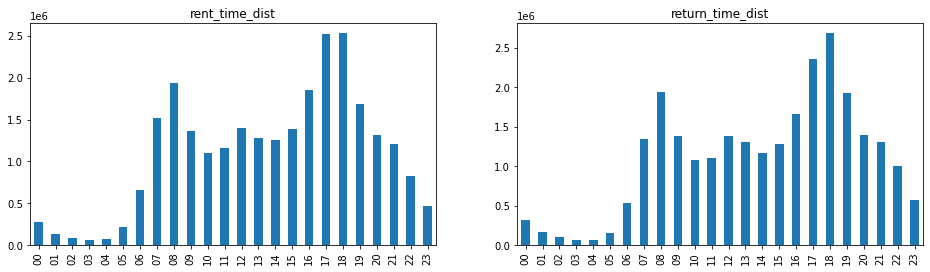

In [258]:
# see the distribution of rent and return time period
plt.subplot(221)
df_rides['rent_time_hr'].value_counts()[sorted(df_rides['rent_time_hr'].unique())].plot(kind='bar', title='rent_time_dist', figsize=(16,9))

plt.subplot(222)
df_rides['return_time_hr'].value_counts()[sorted(df_rides['return_time_hr'].unique())].plot(kind='bar', title='return_time_dist', figsize=(16,9))

<AxesSubplot:title={'center':'rent_minutes_dist'}>

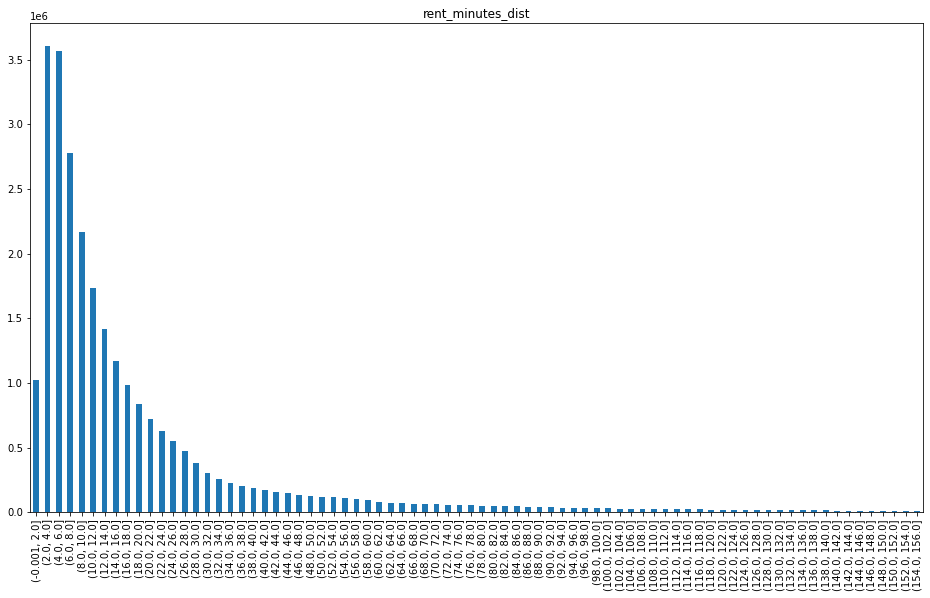

In [262]:
# see the distribution of rent times (under 99% for clear view in x-axis)
plt.subplot()
df_rides['rent_minutes'].value_counts(sort=False, bins=range(0,157,2)).plot(kind='bar', title='rent_minutes_dist', figsize=(16,9))

There are 9.12% of trips rent and return at the same station.


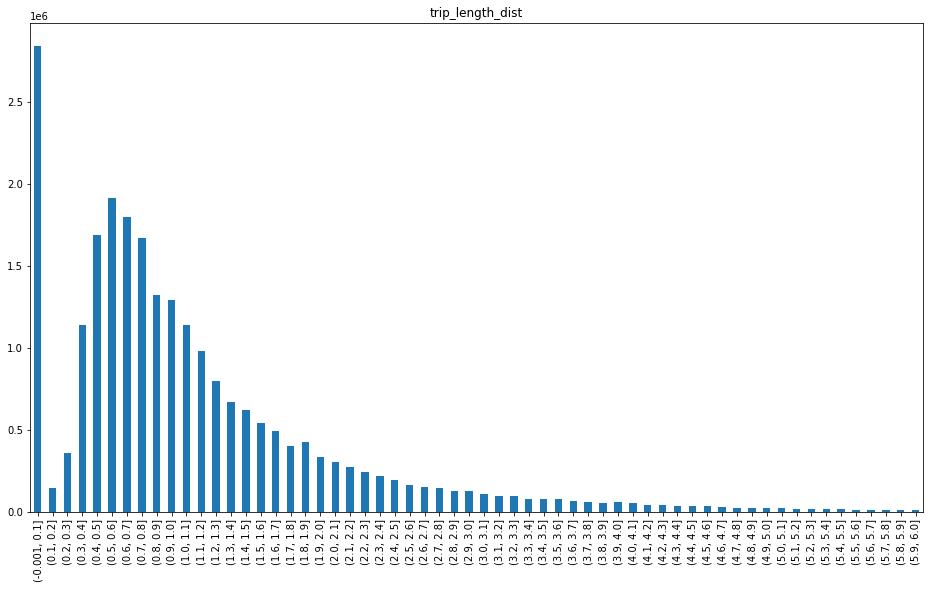

In [263]:
# see the distribution of trip_length[linear distance in km] (under 99% for clear view in x-axis)
plt.subplot()
df_rides['trip_length'].value_counts(sort=False, bins=np.linspace(0,6,61)).plot(kind='bar', title='trip_length_dist', figsize=(16,9))

total_trip = len(df_rides.index)
same_trip = len(df_rides[df_rides['rent_station'] == df_rides['return_station']].index)
print(f'There are {round(total_trip/same_trip,2)}% of trips rent and return at the same station.')

#### Note: 
It is surprising that many people rent and return at the same station, which is the first bar in the trip_length_dist plot. As we can see the first bar in rent_minute_dist is not particularly high, we can tell that most of those trips return to the same station are "real" trips, instead of exceptions, i.e. malfunction bikes.  

p.s. We don't know if the trips "return right after rent" can be seen in the data set

#### EDA Conclusion: 
1. Morning peak at 8am, evening peak from 4pm to 7pm
2. Most of the trips are within 6km, and in 157 minutes

#### Analysis decision:
1. All trips with complete OD are to be used, since trips in (return) and out(rent) can be counted
2. 850m (half of 1.7km) as radius selection for the next analysis

## Analysis Algorithm

In [264]:
# df to be used: df_rides, df_station_info

# counting the "exposure"(ridership), both in(return) and out(rent) are counted
rides_rent_list = [] 
rides_return_list = []
rides_all_list = []

station_list = df_station_info['station'].to_list()
ver_list = df_station_info['Youbike_version'].to_list()

for station, ver in zip(station_list, ver_list):
    
    df_temp_rent = df_rides[(df_rides['rent_station'] == station) & (df_rides['Youbike_version']==ver)]
    rent_count = len(df_temp_rent.index)

    df_temp_return = df_rides[(df_rides['return_station']==station) & (df_rides['Youbike_version']==ver)]
    return_count = len(df_temp_return.index)
    
    rides_rent_list.append(rent_count)
    rides_return_list.append(return_count)
    rides_all_list.append(rent_count+return_count)
    
df_station_info['count_rent'] = pd.Series(rides_rent_list)
df_station_info['count_return'] = pd.Series(rides_return_list)
df_station_info['count_all'] = pd.Series(rides_all_list)

# to save after running 
# this action is an unknown solution for the later calculatioin
# the column with float number seems to be uncertain when use the df directly
# saving it to local dir and reload it seems to work in my computer 
df_station_info.to_csv('data/df_station_info.csv', index=False)

df_station_info

station            lat            lng  Youbike_version  \
0       捷運市政府站(3號出口)  25.0408578889  121.567904444                1   
1     捷運國父紀念館站(2號出口)      25.041254      121.55742                1   
2               市民廣場  25.0360361111     121.562325                1   
3               興雅國中  25.0365638889    121.5686639                1   
4             臺北南山廣場      25.034047     121.565973                1   
...              ...            ...            ...              ...   
1121       臺大總圖書館西南側        25.0169      121.54031                2   
1122         臺大黑森林西側       25.01995      121.54347                2   
1123         臺大獸醫館南側       25.01791      121.54242                2   
1124       臺大新體育館東南側       25.02112      121.53591                2   
1125   臺大明達館北側(員工宿舍)       25.01816      121.54469                2   

      count_rent  count_return  count_all  
0         157561        139112     296673  
1         113174        107719     220893  
2          18632         15606      34238  
3          93560        103968     197528  
4          72932         72639     145571  
...          ...           ...        ...  
1121       16273         15347      31620  
1122       11384         10359      21743  
1123       11407          9934      21341  
1124        5742          5983      11725  
1125        8206          8880      17086  

[1501 rows x 7 columns]

In [11]:
# the block above might take a long time
# use following code directly to access backup csv directly without running the above block to bypass when needed

# reload the file
df_station_info = pd.read_csv('data/df_station_info.csv')

### Algorithm 1: Single Station Risk Score

In [12]:
# step 0: make sure the coordinates are in float type for calculation
df_station_info['lat'] = df_station_info['lat'].astype(float)
df_station_info['lng'] = df_station_info['lng'].astype(float)
df_acc_bike['X'] = df_acc_bike['X'].astype(float)
df_acc_bike['Y'] = df_acc_bike['Y'].astype(float)

In [13]:
# calculate the accident in risk radius

##########################################################
# radius to account risk = 850m, aquired from EDA (1.7/2 = 0.85)
risk_r = 0.85
##########################################################


# step 1: count the number of accident near the station
list_lng1 = df_station_info['lng'].to_list()
list_lat1 = df_station_info['lat'].to_list()
list_lng2 = df_acc_bike['X'].to_list()
list_lat2 = df_acc_bike['Y'].to_list()

list_count_acc_algo1 = []

for lng1, lat1 in zip(list_lng1,list_lat1):
    count = 0
    for lng2, lat2 in zip(list_lng2,list_lat2):
        temp_dist = get_gpsDistance(lat1, lng1, lat2, lng2)
        if 0 < temp_dist < risk_r: 
            count += 1
    list_count_acc_algo1.append(count)


df_station_info['count_acc_Algo1'] = pd.Series(list_count_acc_algo1)
df_station_info  

station        lat         lng  Youbike_version  count_rent  \
0       捷運市政府站(3號出口)  25.040858  121.567904                1      157561   
1     捷運國父紀念館站(2號出口)  25.041254  121.557420                1      113174   
2               市民廣場  25.036036  121.562325                1       18632   
3               興雅國中  25.036564  121.568664                1       93560   
4             臺北南山廣場  25.034047  121.565973                1       72932   
...              ...        ...         ...              ...         ...   
1496       臺大總圖書館西南側  25.016900  121.540310                2       16273   
1497         臺大黑森林西側  25.019950  121.543470                2       11384   
1498         臺大獸醫館南側  25.017910  121.542420                2       11407   
1499       臺大新體育館東南側  25.021120  121.535910                2        5742   
1500   臺大明達館北側(員工宿舍)  25.018160  121.544690                2        8206   

      count_return  count_all  count_acc_Algo1  
0           139112     296673               39  
1           107719     220893               39  
2            15606      34238               58  
3           103968     197528               43  
4            72639     145571               56  
...            ...        ...              ...  
1496         15347      31620               33  
1497         10359      21743               36  
1498          9934      21341               28  
1499          5983      11725               31  
1500          8880      17086               33  

[1501 rows x 8 columns]

In [14]:
# step 2: calculate the risk score by applying risk = exposure('count_all') x hazzard('count_acc_Algo1')
df_station_info['risk_score_Algo1'] = df_station_info['count_all']*df_station_info['count_acc_Algo1']

# rank by risk score
df_station_info['rank_Algo1'] = df_station_info['risk_score_Algo1'].rank(ascending=False)
df_station_info.sort_values('rank_Algo1').head(10)

station        lat         lng  Youbike_version  count_rent  \
770          金華杭州南路口  25.031000  121.522110                2      263391   
446  臨江街夜市(通化街101巷口)  25.029520  121.554060                2      127448   
375          捷運科技大樓站  25.026050  121.543600                2      157561   
127      捷運永春站(2號出口)  25.040558  121.575372                1      111625   
63       捷運台北101/世貿站  25.032752  121.561645                1      115689   
0       捷運市政府站(3號出口)  25.040858  121.567904                1      157561   
455      捷運大安站(4號出口)  25.033200  121.543900                2      118032   
483          樂利路21巷口  25.027700  121.551320                2       85398   
80             捷運大安站  25.033078  121.543057                1      118032   
502      捷運大安站(6號出口)  25.034790  121.543760                2      111625   

     count_return  count_all  count_acc_Algo1  risk_score_Algo1  rank_Algo1  
770        295496     558887               43          24032141         1.0  
446        118367     245815               66          16223790         2.0  
375        139112     296673               50          14833650         3.0  
127        108167     219792               61          13407312         4.0  
63         105880     221569               60          13294140         5.0  
0          139112     296673               39          11570247         6.0  
455        108476     226508               47          10645876         7.0  
483         94736     180134               58          10447772         8.0  
80         108476     226508               46          10419368         9.0  
502        108167     219792               47          10330224        10.0

### Algorithm 2: Multiple Station Risk Score

In [15]:
# calculate the number of "station" from "each accident" in the risk radius
# assign the ratio of each accident to the station in the radius
# the ratio is calculate inversely with the distance from accident to station

##########################################################
# radius to account risk = 850m, aquired from EDA (1.7/2 = 0.85)
risk_r = 0.85
##########################################################


# step 1: calculate the weighted number of accident near the station
df_station_info['count_acc_Algo2'] = 0

# column to verify calculation, should be equal to count_acc_Algo1
df_station_info['verify_acc'] = 0

list_lng1 = df_station_info['lng'].to_list()
list_lat1 = df_station_info['lat'].to_list()
list_lng2 = df_acc_bike['X'].to_list()
list_lat2 = df_acc_bike['Y'].to_list()

for lng2, lat2 in zip(list_lng2,list_lat2):
    list_dist = []
    list_count_acc = []
    
    for lng1, lat1 in zip(list_lng1,list_lat1):
        temp_dist = get_gpsDistance(lat2, lng2, lat1, lng1)
        if 0 < temp_dist < risk_r: 
            list_dist.append(temp_dist)
            list_count_acc.append(1)
        else:
            list_dist.append(0)
            list_count_acc.append(0)
            
    list_dist_r = [1/x if x > 0 else 0 for x in list_dist]
    temp_sum = sum(list_dist_r)
    
    if temp_sum > 0: 
        list_to_plus = [y/temp_sum for y in list_dist_r]
    else: 
        list_to_plus = 0
        
    df_station_info['count_acc_Algo2'] += list_to_plus
    df_station_info['verify_acc'] += list_count_acc

df_station_info

station        lat         lng  Youbike_version  count_rent  \
0       捷運市政府站(3號出口)  25.040858  121.567904                1      157561   
1     捷運國父紀念館站(2號出口)  25.041254  121.557420                1      113174   
2               市民廣場  25.036036  121.562325                1       18632   
3               興雅國中  25.036564  121.568664                1       93560   
4             臺北南山廣場  25.034047  121.565973                1       72932   
...              ...        ...         ...              ...         ...   
1496       臺大總圖書館西南側  25.016900  121.540310                2       16273   
1497         臺大黑森林西側  25.019950  121.543470                2       11384   
1498         臺大獸醫館南側  25.017910  121.542420                2       11407   
1499       臺大新體育館東南側  25.021120  121.535910                2        5742   
1500   臺大明達館北側(員工宿舍)  25.018160  121.544690                2        8206   

      count_return  count_all  count_acc_Algo1  risk_score_Algo1  rank_Algo1  \
0           139112     296673               39          11570247         6.0   
1           107719     220893               39           8614827        17.0   
2            15606      34238               58           1985804       322.0   
3           103968     197528               43           8493704        18.0   
4            72639     145571               56           8151976        23.0   
...            ...        ...              ...               ...         ...   
1496         15347      31620               33           1043460       589.0   
1497         10359      21743               36            782748       694.0   
1498          9934      21341               28            597548       776.0   
1499          5983      11725               31            363475       937.0   
1500          8880      17086               33            563838       802.0   

      count_acc_Algo2  verify_acc  
0            1.393266          39  
1            1.376835          39  
2            1.220562          58  
3            0.850292          43  
4            0.948401          56  
...               ...         ...  
1496         0.298145          33  
1497         0.443765          36  
1498         0.313048          28  
1499         0.328815          31  
1500         0.537381          33  

[1501 rows x 12 columns]

In [22]:
# step 2: calculate the risk score by applying risk = exposure('count_all') x hazzard('count_acc_Algo2')
df_station_info['risk_score_Algo2'] = df_station_info['count_all']*df_station_info['count_acc_Algo2']

# rank by risk score
df_station_info['rank_Algo2'] = df_station_info['risk_score_Algo2'].rank(ascending=False)
df_station_info.sort_values('rank_Algo2', inplace=True)
df_station_info.head(10)

station        lat         lng  Youbike_version  count_rent  \
770         金華杭州南路口  25.031000  121.522110                2      263391   
638         社子島島頭公園  25.108930  121.466390                2       28630   
455     捷運大安站(4號出口)  25.033200  121.543900                2      118032   
643          福安消防分隊  25.096690  121.497060                2       18970   
0      捷運市政府站(3號出口)  25.040858  121.567904                1      157561   
87            捷運景美站  24.993254  121.541059                1       63492   
80            捷運大安站  25.033078  121.543057                1      118032   
1    捷運國父紀念館站(2號出口)  25.041254  121.557420                1      113174   
127     捷運永春站(2號出口)  25.040558  121.575372                1      111625   
18           信義建國路口  25.032930  121.537470                1       84249   

     count_return  count_all  count_acc_Algo1  risk_score_Algo1  rank_Algo1  \
770        295496     558887               43          24032141         1.0   
638         27481      56111               16            897776       639.0   
455        108476     226508               47          10645876         7.0   
643         19921      38891               13            505583       833.0   
0          139112     296673               39          11570247         6.0   
87          44585     108077               30           3242310       162.0   
80         108476     226508               46          10419368         9.0   
1          107719     220893               39           8614827        17.0   
127        108167     219792               61          13407312         4.0   
18          79457     163706               44           7203064        30.0   

     count_acc_Algo2  verify_acc  risk_score_Algo2  rank_Algo2  
770         0.911151          43     509230.348803         1.0  
638         7.943344          16     445708.965992         2.0  
455         1.924076          47     435818.584277         3.0  
643        10.798584          13     419967.711232         4.0  
0           1.393266          39     413344.318415         5.0  
87          3.366767          30     363870.038518         6.0  
80          1.484218          46     336187.229160         7.0  
1           1.376835          39     304133.172803         8.0  
127         1.366718          61     300393.629744         9.0  
18          1.832994          44     300072.056376        10.0

## Visualization: Mapping through Folium

In [16]:
# draw station with highest risk rank : df_station_info
# draw accident: df_acc_bike
# draw top 50 stations, with 10 highlighted

In [17]:
import folium 

In [18]:
# function to create folium map
def create_map(acc,station):
    ##########################################################
    # radius to account risk = 850m, aquired from EDA (1.7/2 = 0.85)
    risk_r = 0.85
    ##########################################################
    m = folium.Map(location=[station['lat'].mean(), station['lng'].mean()], zoom_start=12, tiles='OpenStreetMap')
   
    
    for _, row in acc.iterrows():
         
        if row['condition']=='out':
            cluster_colour='blue'
        else:
            cluster_colour = '#cc00ff' 
            cluster_colour = '#cc00cc'
        
        folium.CircleMarker(
            location= [row['Y'],row['X']],
            radius=4,
            popup= f"{int(row['發生年'])+1911}/{int(row['發生月'])}/{int(row['發生日'])}",
            color=cluster_colour,
            fill=True,
            fill_color=cluster_colour
            ).add_to(m)
    
    for _, row in station.iterrows(): 

        html = popup_html(row)
        popup = folium.Popup(folium.Html(html, script=True), max_width=500)
        
        if row['rank'] <= 10:
            folium.Marker(
                location= [row['lat'],row['lng']],
                radius=5,
                popup=popup,
                icon=folium.Icon(color='orange', icon_color='white', icon='exclamation', prefix='fa'),# or darked blue'info-sign'
            ).add_to(m)
        else:
            folium.Marker(
                location= [row['lat'],row['lng']],
                radius=5,
                popup=popup,
            ).add_to(m)

        folium.Circle(
            location= [row['lat'],row['lng']],
            radius=risk_r*1000,
            popup= f"Rank:{int(row['rank'])}",
            color='#29293d',
            fill=False,
        ).add_to(m)

#     for _, row in station.iterrows(): 

        
    return m

In [19]:
# html for drawing map

def popup_html(row):
    
#     institution_name=df['INSTNM'].iloc[i] 
#     institution_url=df['URL'].iloc[i]
#     institution_type = df['CONTROL'].iloc[i] 
#     highest_degree=df['HIGHDEG'].iloc[i] 
#     city_state = df['CITY'].iloc[i] +", "+ df['STABBR'].iloc[i]                     
#     admission_rate = df['ADM_RATE'].iloc[i]
#     cost = df['COSTT4_A'].iloc[i]
#     instate_tuit = df['TUITIONFEE_IN'].iloc[i]
#     outstate_tuit = df['TUITIONFEE_OUT'].iloc[i]
    
    station_name = row['station']
    Youbike_sys = row['Youbike_version']
    position = (round(row['lat'],5), round(row['lng'],5))
    rent12 = row['count_rent']
    ret12 = row['count_return']
    acc_in = row['count_acc_Algo1']
    
    left_col_color = "#19a7bd"
    right_col_color = "#f2f0d3"
    rank = int(row['rank'])
    
    html = """<!DOCTYPE html>
    
    
<html>
<head>
<h4 style="margin-bottom:10"; width="200px">{}</h4>""".format(station_name) + """
</head>
    <table style="height: 126px; width: 350px;">
<tbody>
<tr>
<td style="background-color: """+ left_col_color +""";"><span style="color: #ffffff;"> Youbike System </span></td>
<td style="width: 150px;background-color: """+ right_col_color +""";">{}</td>""".format('Youbike '+str(Youbike_sys)+'.0') + """
</tr>
<tr>
<td style="background-color: """+ left_col_color +""";"><span style="color: #ffffff;"> Coordinates </span></td>
<td style="width: 150px;background-color: """+ right_col_color +""";">{}</td>""".format(position) + """
</tr>
<tr>
<td style="background-color: """+ left_col_color +""";"><span style="color: #ffffff;"> Rent in 12 months </span></td>
<td style="width: 150px;background-color: """+ right_col_color +""";">{}</td>""".format(rent12) + """
</tr>
<tr>
<td style="background-color: """+ left_col_color +""";"><span style="color: #ffffff;"> Return in 12 months </span></td>
<td style="width: 150px;background-color: """+ right_col_color +""";">{}</td>""".format(ret12) + """
</tr>
<tr>
<td style="background-color: """+ left_col_color +""";"><span style="color: #ffffff;"> Accidents within radius </span></td>
<td style="width: 150px;background-color: """+ right_col_color +""";">{}</td>""".format(acc_in) + """
</tr>
<tr>
<td style="background-color: """+ left_col_color +""";"><span style="color: #ffffff;"> Rank of Risk </span></td>
<td style="width: 150px;background-color: """+ right_col_color +""";">{}</td>""".format(int(rank)) + """
</tr>
</tbody>
</table>
</html>
"""
    return html

In [20]:
df_risk1 = df_station_info.sort_values('rank_Algo1').head(50)
list_acc_lng = df_acc_bike['X'].tolist()
list_acc_lat = df_acc_bike['Y'].tolist()
list_risk_lng = df_risk1['lng'].tolist()
list_risk_lat = df_risk1['lat'].tolist()

list_temp_con = []

##########################################################
# radius to account risk = 850m, aquired from EDA (1.7/2 = 0.85)
risk_r = 0.85
##########################################################

for lng1, lat1 in zip(list_acc_lng, list_acc_lat):
    temp_con = 'out'
    for lng2, lat2 in zip(list_risk_lng, list_risk_lat):
        temp_dist = get_gpsDistance(lat1, lng1, lat2, lng2)
        if temp_dist < risk_r: 
            temp_con = 'in'
            break
    list_temp_con.append(temp_con)
df_acc_bike['condition'] = list_temp_con
df_risk1['rank'] = df_risk1['rank_Algo1']
m1 = create_map(df_acc_bike,df_risk1)
m1

In [23]:
df_risk2 = df_station_info.sort_values('rank_Algo2').head(50)
list_acc_lng = df_acc_bike['X'].tolist()
list_acc_lat = df_acc_bike['Y'].tolist()
list_risk_lng = df_risk2['lng'].tolist()
list_risk_lat = df_risk2['lat'].tolist()

list_temp_con = []

##########################################################
# radius to account risk = 850m, aquired from EDA (1.7/2 = 0.85)
risk_r = 0.85
##########################################################

for lng1, lat1 in zip(list_acc_lng, list_acc_lat):
    temp_con = 'out'
    for lng2, lat2 in zip(list_risk_lng, list_risk_lat):
        temp_dist = get_gpsDistance(lat1, lng1, lat2, lng2)
        if temp_dist < risk_r:
            temp_con = 'in'
            break
    list_temp_con.append(temp_con)
df_acc_bike['condition'] = list_temp_con
df_risk2['rank'] = df_risk2['rank_Algo2']
m2 = create_map(df_acc_bike,df_risk2)
m2

In [321]:
# save the results
m1.save("output/m1.html")
m2.save("output/m2.html")